# Convolutional Neural Network Tutorial (CNN)

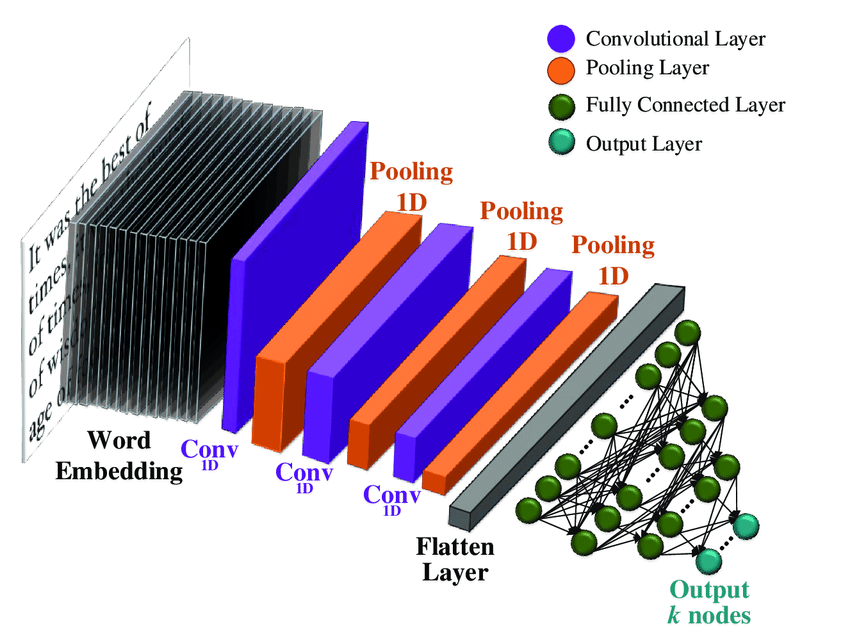

Text Classification Using Convolutional Neural Network (CNN) :
CNN is a class of deep, feed-forward artificial neural networks ( where connections between nodes do not form a cycle) & use a variation of multilayer perceptrons designed to require minimal preprocessing

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from gensim.models import Word2Vec
import itertools
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,load_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from keras.utils.vis_utils import plot_model

df = pd.read_csv('cleaned_IMDB.csv')
df.head()

,review,cleaned_bert_review,cleaned_review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,bromwell high is a cartoon comedy it ran at th...,bromwell high cartoon comedy run time program ...,1
1,Homelessness (or Houselessness as George Carli...,homelessness or houselessness as george carlin...,homelessness houselessness george carlin state...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,brilliant overacting by lesley ann warren best...,brilliant overact lesley ann warren well drama...,1
3,This is easily the most underrated film inn th...,this is easily the most underrated film inn th...,easily underrated film inn brooks cannon sure ...,1
4,This is not the typical Mel Brooks film. It wa...,this is not the typical mel brooks film it was...,not typical mel brooks film much less slapstic...,1


In [ ]:
df["sentiment"] = df["sentiment"].replace("pos",1)
df["sentiment"] = df["sentiment"].replace("neg",0)
df.head()

,review,cleaned_bert_review,cleaned_review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,bromwell high is a cartoon comedy it ran at th...,bromwell high cartoon comedy run time program ...,1
1,Homelessness (or Houselessness as George Carli...,homelessness or houselessness as george carlin...,homelessness houselessness george carlin state...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,brilliant overacting by lesley ann warren best...,brilliant overact lesley ann warren well drama...,1
3,This is easily the most underrated film inn th...,this is easily the most underrated film inn th...,easily underrated film inn brooks cannon sure ...,1
4,This is not the typical Mel Brooks film. It wa...,this is not the typical mel brooks film it was...,not typical mel brooks film much less slapstic...,1


In [ ]:
df.shape

(50000, 4)

In [ ]:
# Check the dataset is balanced or not
df.groupby('sentiment')["sentiment"].count()

sentiment
0    25000
1    25000
Name: sentiment, dtype: int64

In [ ]:
# View the top 25000 data
df.head(25000)

,review,cleaned_bert_review,cleaned_review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,bromwell high is a cartoon comedy it ran at th...,bromwell high cartoon comedy run time program ...,1
1,Homelessness (or Houselessness as George Carli...,homelessness or houselessness as george carlin...,homelessness houselessness george carlin state...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,brilliant overacting by lesley ann warren best...,brilliant overact lesley ann warren well drama...,1
3,This is easily the most underrated film inn th...,this is easily the most underrated film inn th...,easily underrated film inn brooks cannon sure ...,1
4,This is not the typical Mel Brooks film. It wa...,this is not the typical mel brooks film it was...,not typical mel brooks film much less slapstic...,1
...,...,...,...,...
24995,"Towards the end of the movie, I felt it was to...",towards the end of the movie i felt it was too...,towards end movie feel technical feel like cla...,0
24996,This is the kind of movie that my enemies cont...,this is the kind of movie that my enemies cont...,kind movie enemy content watch time not bloody...,0
24997,I saw 'Descent' last night at the Stockholm Fi...,i saw descent last night at the stockholm film...,see descent last night stockholm film festival...,0
24998,Some films that you pick up for a pound turn o...,some films that you pick up for a pound turn o...,film pick pound turn rather good 23rd century ...,0


# Train test split


Tokenizer for column cleaned_review

In [ ]:
tokenizer = Tokenizer()

imdb = df['cleaned_review'].values.tolist()
tokenizer.fit_on_texts(imdb)

In [ ]:
sequences = []
max_sequence_len = 0

for text in imdb:
    # Convert texts to sequence
    txt_to_seq = tokenizer.texts_to_sequences([text])[0]
    sequences.append(txt_to_seq)
    # Find max_sequence_len for padding
    length = len(txt_to_seq)
    if length > max_sequence_len:
        max_sequence_len = length

In [ ]:
padded_sequences = pad_sequences(sequences, 
                                 maxlen=max_sequence_len, 
                                 padding='post',
                                 truncating='post')

Define X,Y train and test

In [ ]:
X_train = padded_sequences[25000:]
X_test = padded_sequences[:25000]

y_train = df['sentiment'].iloc[25000:]
y_test = df['sentiment'].iloc[:25000]

Set vocab size and max length

In [ ]:
#  define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

#Modeling

A conservative CNN configuration is used with 32 filters (parallel fields for processing words) and a kernel size of 8 with a rectified linear (‘relu’) activation function. This is followed by a pooling layer that reduces the output of the convolutional layer by half.

Next, the 2D output from the CNN part of the model is flattened to one long 2D vector to represent the ‘features’ extracted by the CNN. The back-end of the model is a standard Multilayer Perceptron layers to interpret the CNN features. The output layer uses a sigmoid activation function to output a value between 0 and 1 for the negative and positive sentiment in the review.

In [ ]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_len))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1430, 100)         20417700  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1423, 32)          25632     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 711, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 22752)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                227530    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 20,670,873
Trainable params: 20,670,873
Non-trainable params: 0
__________________________________________

In [ ]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall'])

In [ ]:
# fit network
history = model.fit(X_train, y_train.values, epochs=25, verbose=2,validation_split=0.1,batch_size=64)

Epoch 1/25
352/352 - 144s - loss: 0.5051 - accuracy: 0.7781 - precision: 0.7409 - recall: 0.9236 - val_loss: 0.7246 - val_accuracy: 0.8380 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
352/352 - 145s - loss: 0.3018 - accuracy: 0.9364 - precision: 0.9484 - recall: 0.9364 - val_loss: 0.7374 - val_accuracy: 0.8372 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
352/352 - 141s - loss: 0.2088 - accuracy: 0.9675 - precision: 0.9841 - recall: 0.9569 - val_loss: 0.8125 - val_accuracy: 0.8592 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
352/352 - 135s - loss: 0.1624 - accuracy: 0.9778 - precision: 0.9946 - recall: 0.9653 - val_loss: 0.9667 - val_accuracy: 0.8480 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
352/352 - 141s - loss: 0.1334 - accuracy: 0.9815 - precision: 0.9978 - recall: 0.9689 - val_loss: 0.9305 - val_accuracy: 0.8632 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/25
352/352 - 145s - loss: 0.1137

#Evaluation

In [ ]:
# evaluate
loss, acc,pre,recall = model.evaluate(X_train, y_train, verbose=2)
print('Train Loss: %f' % (loss*100))
print('Train Accuracy: %f' % (acc*100))
print('Train Precision: %f' % (pre*100))
print('Train Recall: %f' % (recall*100))

782/782 - 15s - loss: 0.1869 - accuracy: 0.9781 - precision: 0.9740 - recall: 0.9824
Train Loss: 18.687890
Train Accuracy: 97.807997
Train Precision: 97.398478
Train Recall: 98.240000


In [ ]:
# evaluate
loss, acc,pre,recall = model.evaluate(X_test, y_test, verbose=2)
print('Test Loss: %f' % (loss*100))
print('Test Accuracy: %f' % (acc*100))
print('Test Precision: %f' % (pre*100))
print('Test Recall: %f' % (recall*100))

782/782 - 16s - loss: 0.9157 - accuracy: 0.8460 - precision: 0.8721 - recall: 0.8110
Test Loss: 91.565984
Test Accuracy: 84.604001
Test Precision: 87.208605
Test Recall: 81.103998


#Save model

In [ ]:
model.save('C:/Users/Acer/Desktop/CNN')

INFO:tensorflow:Assets written to: C:/Users/Acer/Desktop/CNN\assets


Load model

In [ ]:
model = load_model('C:/Users/Acer/Desktop/CNN')

#Prediction

In [ ]:
y_pred = model.predict(X_test) 

In [ ]:
for i in range(len(X_test)):
    print("X=%s, Predicted=%s" % (X_test[i], y_pred[i]))
    

X=[25581   185   666 ...     0     0     0], Predicted=[0.9999998]
X=[24099 71087   567 ...     0     0     0], Predicted=[0.02335146]
X=[  419  1987 13506 ...     0     0     0], Predicted=[1.]
X=[ 591 1804    3 ...    0    0    0], Predicted=[0.9999589]
X=[   1  641 2783 ...    0    0    0], Predicted=[0.99999976]
X=[   1 1433 1565 ...    0    0    0], Predicted=[0.992028]
X=[ 349  333 2658 ...    0    0    0], Predicted=[0.9998929]
X=[8597 3548 1648 ...    0    0    0], Predicted=[0.5664903]
X=[ 202 8119 2830 ...    0    0    0], Predicted=[0.9999783]
X=[  28 1565 1454 ...    0    0    0], Predicted=[1.]
X=[   35   165 32339 ...     0     0     0], Predicted=[0.02335146]
X=[  7   3 108 ...   0   0   0], Predicted=[0.9999997]
X=[  46 3510  654 ...    0    0    0], Predicted=[1.]
X=[ 113  202 8119 ...    0    0    0], Predicted=[1.]
X=[ 202 8119  145 ...    0    0    0], Predicted=[0.9997699]
X=[  7   4 753 ...   0   0   0], Predicted=[0.02335146]
X=[ 202 8119  351 ...    0    0    0]

Set predicted result to 0(negative) and 1(positive) only

In [ ]:
sentiment_predict = []

for i in y_pred:
    if i > 0.5:
        sentiment_predict.append(1)
    else:
        sentiment_predict.append(0)

In [ ]:
print (sentiment_predict)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 

#Visualization

Plot confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['Negative','Positive']

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     12500
           1       0.87      0.81      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Confusion matrix, without normalization
[[11013  1487]
 [ 2362 10138]]


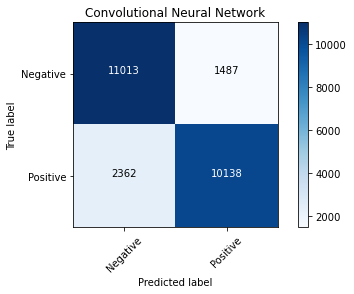

In [ ]:
print(classification_report(y_test, sentiment_predict))
cm = confusion_matrix(y_test, sentiment_predict)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Convolutional Neural Network')

In [ ]:
print('True Negative  : %d' % cm[0][0])
print('False Positive : %d' % cm[0][1])
print('False Negative : %d' % cm[1][0])
print('True Positive  : %d' % cm[1][1])

True Negative  : 11013
False Positive : 1487
False Negative : 2362
True Positive  : 10138


Overall Score Graph

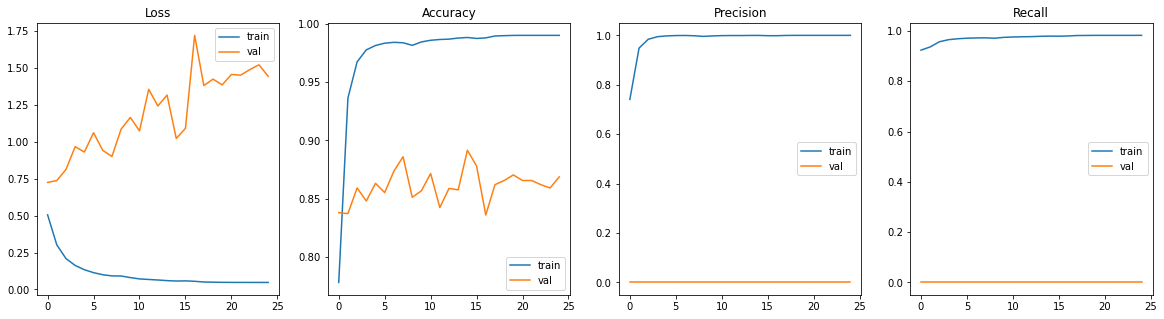

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].set_title('Loss')
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(history.history['precision'], label='train')
axs[2].plot(history.history['val_precision'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(history.history['recall'], label='train')
axs[3].plot(history.history['val_recall'], label='val')
axs[3].legend()

Main Focus Accuracy

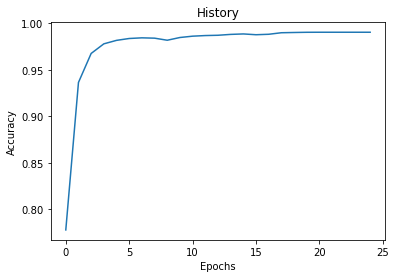

In [ ]:
import matplotlib.pyplot as plt
fig = plt.plot(history.history['accuracy'])
title = plt.title("History")
xlabel = plt.xlabel("Epochs")
ylabel = plt.ylabel("Accuracy")

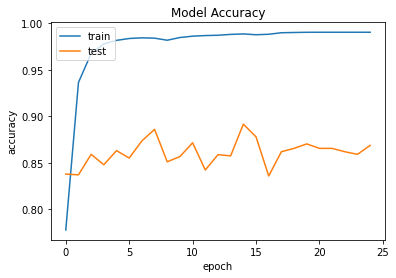

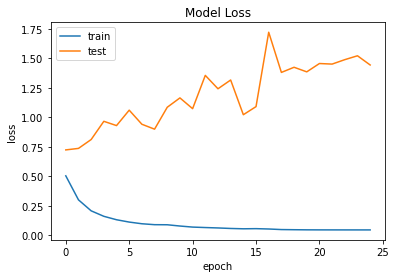

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Plot model

In [ ]:
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

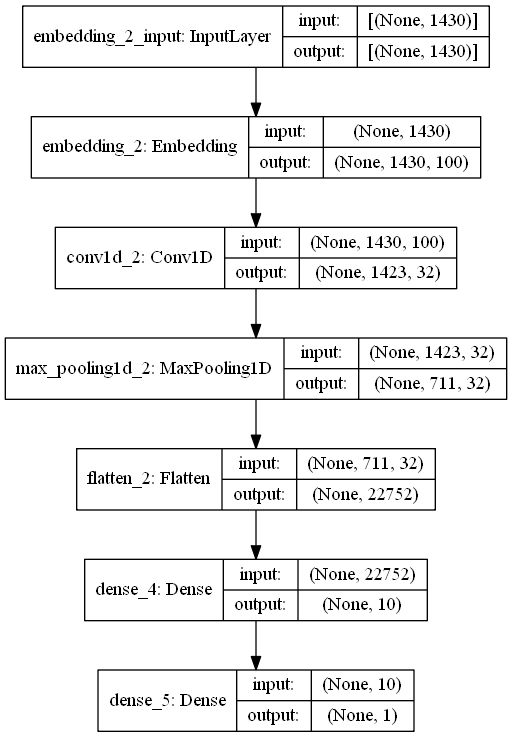

In [ ]:
plot_model(model, to_file='C:/Users/Acer/Desktop/model_plot.png', show_shapes=True, show_layer_names=True)

# Summary

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,roc_curve, roc_auc_score, auc

print('Test Accuracy: %f' % (accuracy_score(y_test,sentiment_predict,normalize=True)*100))
print('Test Precision: %f' % (precision_score(y_test,sentiment_predict)*100))
print('Test F1 Score: %f' % (f1_score(y_test,sentiment_predict)*100))
print('Test Recall: %f' % (recall_score(y_test,sentiment_predict)*100))


Test Accuracy: 84.604000
Test Precision: 87.208602
Test F1 Score: 84.045596
Test Recall: 81.104000


#Grid Search CV

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

Define model in def

In [ ]:
def create_model():
    # define model
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_sequence_len))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall'])
    return model

Create model with keras classifier

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [64]
epochs = [1]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.601561 using {'batch_size': 64, 'epochs': 1}
0.601561 (0.197093) with: {'batch_size': 64, 'epochs': 1}


Train model

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [32,64]
epochs = [1,5]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.769442 using {'batch_size': 32, 'epochs': 5}
0.726764 (0.080990) with: {'batch_size': 32, 'epochs': 1}
0.769442 (0.041215) with: {'batch_size': 32, 'epochs': 5}
0.602531 (0.213556) with: {'batch_size': 64, 'epochs': 1}
0.623559 (0.089774) with: {'batch_size': 64, 'epochs': 5}


#Result

In [ ]:
for params, scores in zip(grid_result.cv_results_['params'], grid_result.cv_results_['mean_test_score']):
  print(params, scores)

{'batch_size': 32, 'epochs': 1} 0.7267638246218363
{'batch_size': 32, 'epochs': 5} 0.7694419026374817
{'batch_size': 64, 'epochs': 1} 0.6025310754776001
{'batch_size': 64, 'epochs': 5} 0.6235585312048594


In [ ]:
# Print the tuned parameters and score
print(f'Best Score: {grid_result.best_score_}')
print(f'Best Parameter List: {grid_result.best_params_}')
print(f'Best Estimator: {grid_result.best_estimator_}')

Best Score: 0.7694419026374817
Best Parameter List: {'batch_size': 32, 'epochs': 5}
Best Estimator: <keras.wrappers.scikit_learn.KerasClassifier object at 0x00000220D77024F0>


In [ ]:
grid_result.cv_results_

{'mean_fit_time': array([1143.99746259, 4523.7503647 ,  771.2196149 , 3111.29467861]),
 'std_fit_time': array([ 2.30049065,  6.5784474 ,  4.48127997, 57.82834328]),
 'mean_score_time': array([39.818302  , 10.946944  , 38.30609465, 24.27844453]),
 'std_score_time': array([1.41397538, 2.56188279, 3.10840684, 3.2127724 ]),
 'param_batch_size': masked_array(data=[32, 32, 64, 64],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[1, 5, 1, 5],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 32, 'epochs': 1},
  {'batch_size': 32, 'epochs': 5},
  {'batch_size': 64, 'epochs': 1},
  {'batch_size': 64, 'epochs': 5}],
 'split0_test_score': array([0.63150948, 0.72138226, 0.32589394, 0.66030717]),
 'split1_test_score': array([0.8294732 , 0.82203287, 0.84579384, 0.49994001]),
 'split2_test_score': array([0.71930879, 0.76491058, 0.635905

In [ ]:
print('Accuracy of CNN on training set: {:.2f}'
     .format(grid_result.best_estimator_.score(X_train, y_train)))
print('Accuracy of CNN on testing set : {:.2f}'
     .format(grid_result.best_estimator_.score(X_test, y_test)))

Accuracy of CNN on training set: 1.00
Accuracy of CNN on testing set : 0.85


#ROC Curve

In [ ]:
def Calculate_Plot_ROC(y_test, y_pred, name):
  # Calculate ROC curve
  fpr, tpr, thr = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr,tpr)

  # Plot the ROC curve
  plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
  plt.plot(fpr, tpr, label ='ROC Curve (Area = %0.2f)' %roc_auc)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title(f'ROC Curve for {name}')
  plt.legend(loc ='best')

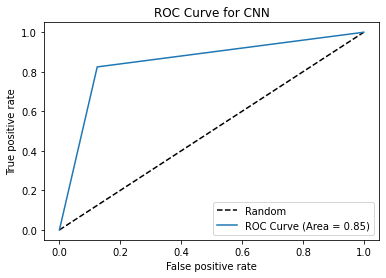

In [ ]:
Calculate_Plot_ROC(y_test, sentiment_predict, 'CNN')